# PyGEM Advanced Test - Tidewater Glaciers

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
Created: 17JAN2025<br> <br>
Objective: build on the [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb) demonstration and go over testing the calibration of the frontal ablation parameterization. If you have yet to do so, we suggest going through the advanced test notebook in full before proceeding.<br>

Note that in a typical regional modeling workflow, the ice viscocity (“Glen A”) model parameter would already be calibrated for the land-terminating glaciers such that the modeled ice volume roughly matches the ice volume estimates (see [run_calibration_icethickness](https://pygem.readthedocs.io/en/latest/run_calibration_icethickness_overview.html#run-calibration-icethickness-overview-target)). Here, we have already provided you with output files, which include this calibration.<br>

This demonstration utilizes PyGEM's *sample_data_tw* for LeConte Glacier (RGI60-01.03622), which should have been downloaded during model installation and setup (see [here](https://pygem.readthedocs.io/en/latest/install_pygem.html)), but can also be downloaded directly [here](https://drive.google.com/file/d/1Wu4ZqpOKxnc4EYhcRHQbwGq95FoOxMfZ/view?usp=drive_link).<br>

> **📝 Note:**<br>
> In this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>

> **⚠️ Warning:**<br>
> Ensure that the `root` parameter in the PyGEM configuration file points to the correct path for the sample dataset (should end in */sample_data_tw/*, not */sample_data/* as was the case for [*simple_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/simple_test.ipynb) and [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb)). Modify the `root` parameter in ~/PyGEM/config.yaml with the text editor of your choice so that the to point to wherever the appropriate sample dataset is located on your computer.

In [1]:
### imports ###
import os, sys, glob, json
from IPython.display import Image, display
import numpy as np
# pygem imports
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.
# get root path
rootpath = pygem_prms["root"]
# reduce oggm logging level to keep notebook clean
config_manager.update_config(updates={'oggm.logging_level' : 'CRITICAL'})

In [2]:
# update path if needed - need to point to tidewater sample dataset
head, tail = os.path.split(rootpath)
if tail == 'sample_data':
    rootpath = os.path.join(head, 'sample_data_tw/')
    config_manager.update_config(updates={'root' : rootpath})

Proceeding with the simple test, the following steps will be completed:
1. Frontal Ablation Calibration
2. Bayesian inference (MCMC) calibration
3. MCMC future simulation

In [3]:
# define glacier number of interest - LeConte 
glac_no = 1.03622

## Frontal Ablation Calibration

Calibrate the frontal ablation paremeterization against observations. The following parameters should either be set within your configuration file, or passed to the *run_calibration* script as command line arguments:
<pre>
glac_no =                   1.03622
ref_startyear =             2000
ref_endyear =               2019
option_calibration =        emulator
include_frontalablation =   False
</pre>

> **📝 Note:**  
> It may feel counterintuitive to set `include_frontalablation = False`; however, this is needed in the initial steps to avoid circularity issues.

In [4]:
# update the include_frontalablation key as described above
config_manager.update_config(updates={'setup.include_frontalablation' : False})

In [5]:
# passing the above parameters as command line arguments:
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration emulator

Processing: ERA5
1 glaciers in region 1 are included in this model run: ['03622']
This study is focusing on 1 glaciers in region [1]
ERA5 : RGI60-01.03622
Total processing time: 8.560395956039429 s


If successful, the script will run without errors and the following datasets will be generated:

* *~/sample_data_tw/Output/calibration/01/1.03622-modelprms_dict.pkl*<br>
* *~/sample_data_tw/Output/emulator/sims/01/1.03622-100_emulator_sims.csv*<br>
* *~/sample_data_tw/Output/emulator/models/01/1.03622-emulator-mb_mwea.pth*<br>
* *~/sample_data_tw/Output/emulator/models/01/1.03622-emulator-mb_mwea_extra.pkl*<br>
* *~/sample_data_tw/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.03/RGI60-01.03622/*<br>

These contain the calibration data, simulations used to create the emulator, and information needed to recreate the emulator. The glacier directory (oggm_gdirs) with relevant glacier information is created automatically as well.

In [6]:
%%bash -s "$rootpath"
ls -lRah $1/Output/

total 0
drwxr-xr-x  4 btober  staff   128B Nov  4 11:58 .
drwxr-xr-x  9 btober  staff   288B Nov  4 11:58 ..
drwxr-xr-x  5 btober  staff   160B Nov  4 11:58 calibration
drwxr-xr-x@ 4 btober  staff   128B Nov  4 11:58 emulator

/Users/btober/PyGEM/sample_data/sample_data_tw//Output//calibration:
total 48
drwxr-xr-x  5 btober  staff   160B Nov  4 11:58 .
drwxr-xr-x  4 btober  staff   128B Nov  4 11:58 ..
drwxr-xr-x@ 3 btober  staff    96B Nov  4 11:58 01
-rw-r--r--  1 btober  staff   1.3K Nov  4 11:58 glena_region.csv
-rw-r--r--  1 btober  staff    16K Nov  4 11:58 priors_region.csv

/Users/btober/PyGEM/sample_data/sample_data_tw//Output//calibration/01:
total 8
drwxr-xr-x@ 3 btober  staff    96B Nov  4 11:58 .
drwxr-xr-x  5 btober  staff   160B Nov  4 11:58 ..
-rw-r--r--@ 1 btober  staff   238B Nov  4 11:58 1.03622-modelprms_dict.json

/Users/btober/PyGEM/sample_data/sample_data_tw//Output//emulator:
total 0
drwxr-xr-x@ 4 btober  staff   128B Nov  4 11:58 .
drwxr-xr-x  4 btober  staff  

Next, run the frontal ablation calibration. Restore the frontal ablation swtich to `True` in the configuration file.<br>

<pre>
include_frontalablation =   True
</pre>

In [7]:
# update the include_frontalablation key as described above
config_manager.update_config(updates={'setup.include_frontalablation' : True})


What are the available arguments for the *run_calibration_frontalablation* script?

In [8]:
!run_calibration_frontalablation -h

2025-11-04 11:58:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-04 11:58:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-04 11:58:50: oggm.cfg: Multiprocessing: using all available processors (N=10)
usage: run_calibration_frontalablation [-h]
                                       [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                                       [-ref_climate_name REF_CLIMATE_NAME]
                                       [-ref_startyear REF_STARTYEAR]
                                       [-ref_endyear REF_ENDYEAR]
                                       [-massbalance_fn MASSBALANCE_FN]
                                       [-massbalance_facorrected_fn MASSBALANCE_FACORRECTED_FN]
                                       [-ncores NCORES]
                                       [-prms_from_reg_priors] [-o] [-v]

Calibrate frontal ablation against reference calving datasets and update th

Since we are dealing with an test glacier from Alaska, we'll pass the appropriate region as a command line argument. We can leave the defaults for most of the available arguements (e.g. `massbalance_fn`, `massbalance_facorrected_fn`, `prms_from_reg_priors`). We'll just pass the most critical ones (this is likely redundant, as several of these parameters are likely set identically in your configuration file).

In [9]:
# passing the above parameters as command line arguments:
!run_calibration_frontalablation -rgi_region01 1 -ref_startyear 2000 -ref_endyear 2019

2025-11-04 11:58:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-04 11:58:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-04 11:58:51: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-11-04 11:58:53: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-04 11:58:53: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-04 11:58:53: oggm.cfg: Multiprocessing: using all available processors (N=10)
1 glaciers in region 1 are included in this model run: ['03622']
This study is focusing on 1 glaciers in region [1]
/Users/btober/Documents/tmp/PyGEM/pygem/bin/run/run_calibration_frontalablation.py:1484: UserWarning: Only one glacier in region 1.
Has the full dataset been downloaded? See documentation for more information: https://pygem.readthedocs.io/en/latest/model_inputs.html#model-inputs
  main_glac_rgi_all = modelsetup.sel

If successful, the script will run without errors and the following datasets will be generated:

* *~/sample_data_tw/frontalablation_data/analysis/1-frontalablation_cal_ind.csv*
* *~/sample_data_tw/frontalablation_data/analysis/all-frontalablation_cal_ind.csv*

The *all-calving_cal_ind* data simply merges all the different regions together, which is essentially pointless for a single glacier test, but useful to get into good workflow habits.

Additionally we should find a frontal ablation corrected reference mass balance dataset:

* *~/sample_data_tw/DEMs/Hugonnet2021/df_pergla_global_20yr-filled-frontalablation-corrected.csv*

The frontal ablation corrected mass balance should also now appear within the *mb_calib_pygem.json* file within the glacier directory.

In [10]:
# check the output - the parameter dictionary output should now have an `HH2015` key
glac_str = f"{glac_no:.{5}f}"
reg = glac_str.split('.')[0].zfill(2)
num = glac_str.split('.')[1]
thous = num[:2]
calib_path = f"{rootpath}/oggm_gdirs/per_glacier/RGI60-{reg}/RGI60-{reg}.{thous}/RGI60-{reg}.{num}/mb_calib_pygem.json"
with open(calib_path, 'r') as f:
    mb_calib = json.load(f)
print(mb_calib)

{'mb_mwea': -1.0383625135276695, 'mb_mwea_err': 0.0965, 'mb_clim_mwea': -1.0373, 'mb_clim_mwea_err': 0.0965, 't1_str': '2000-01-01', 't2_str': '2019-12-31', 'nyears': 20.0}


Now that we have updated mass balance (accounting for frontal ablation), we must recalibrate model parameters. This involves re-running the model calibration to develop an emulator with `include_frontalablation = True`. No parameters should need to be changed in the configuration file at this point, but for sake of clarity, we will run the calibration script with the following settings:
<pre>
glac_no =                   1.03622
ref_startyear =             2000
ref_endyear =               2019
option_calibration =        emulator
include_frontalablation =   True
</pre>

In [11]:
# passing the above parameters as command line arguments:
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration emulator 

Processing: ERA5
1 glaciers in region 1 are included in this model run: ['03622']
This study is focusing on 1 glaciers in region [1]
ERA5 : RGI60-01.03622
Total processing time: 8.758211851119995 s


## MCMC calibration

As was done in the [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb) notebook, we will now perform Bayesian inference MCMC model calibration.

The only updated parameter from previous call of *run_calibration* is the calibration option:
<pre>
option_calibration =  MCMC
</pre>

In [12]:
# passing the above parameters as command line arguments:
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration MCMC  -p # `-v` == vervose (will generate some diagnostic plots) and `-p` == progress bar

Processing: ERA5
1 glaciers in region 1 are included in this model run: ['03622']
This study is focusing on 1 glaciers in region [1]
ERA5 : RGI60-01.03622
20010it [00:15, 1269.29it/s]                                                    
Total processing time: 16.123401880264282 s


## MCMC simulations

You are now ready to run an MCMC simulation. We will run a 10-simulation MCMC model run from 2000-2100 under the CESM2 climate model, shared socioeconomic pathway (SSP) 2-4.5:

<pre>
glac_no =                   1.03622
sim_climate_name =          CESM2
sim_climate_scenario =      ssp245
sim_startyear =             2000
sim_endyear =               2100
option_calibration =        MCMC
nsims =                     10
option_dynamics =           OGGM
use_regional_glen_a =       False     
include_frontalablation =   True
</pre>


In [13]:
# passing the above parameters as command line arguments:
gcm_name = 'CESM2'
scenario = 'ssp245'
!run_simulation -rgi_glac_number {glac_no} -sim_climate_name {gcm_name} -sim_climate_scenario {scenario} -sim_startyear 2000 -sim_endyear 2100 -option_calibration MCMC -nsims 10 -option_dynamics OGGM -use_regional_glen_a False -export_all_simiters -export_extra_vars -export_binned_data -export_binned_components

2025-11-04 11:59:44: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-04 11:59:44: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-04 11:59:44: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-11-04 11:59:44: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2025-11-04 11:59:44: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2025-11-04 11:59:44: oggm.cfg: PARAMS['trapezoid_lambdas'] changed from `2.0` to `1`.
Processing: CESM2 ssp245
Processing with 1 cores...
1 glaciers in region 1 are included in this model run: ['03622']
This study is focusing on 1 glaciers in region [1]
CESM2 : RGI60-01.03622
Total processing time: 17.075089693069458 s


Note the following flags were passed to *run_simulation*:
<pre>
-export_all_simiters            # Exprort individual simulation results
-export_extra_vars              # Export extra variables (temp, prec, melt, acc, etc.)
-export_binned_data             # Export binned ice thickness
-export_binned_components       # Export binned mass balance components (accumulation, melt, refreeze)
</pre>
To turn on these export options, the flags can be passed as demonstrated above, or the values of these parameters can be set to `True` in one's PyGEM confiuration file.<br><br>
If successful, we should see the following simulation dataset:

In [14]:
%%bash -s "$rootpath" "$reg" "$gcm_name" "$scenario"
ls -lah $1/Output/simulations/$2/$3/$4/stats/*10sets*.nc

-rw-r--r--@ 1 btober  staff   346K Nov  4 11:59 /Users/btober/PyGEM/sample_data/sample_data_tw//Output/simulations/01/CESM2/ssp245/stats/1.03622_CESM2_ssp245_MCMC_ba1_10sets_2000_2100_all.nc


## Plot

Visualize the model output. First use xarray to load the netcdf file shown above.

In [15]:
import xarray as xr
ds = xr.open_dataset(glob.glob(f'{rootpath}/Output/simulations/{reg}/{gcm_name}/{scenario}/stats/{glac_no}_{gcm_name}_{scenario}_MCMC_*10sets*_2000_2100_all.nc*')[0])
ds

<xarray.Dataset> Size: 290kB
Dimensions:                              (glac: 1, time: 1212, year: 102)
Coordinates:
  * glac                                 (glac) int64 8B 0
  * time                                 (time) datetime64[ns] 10kB 2000-01-0...
  * year                                 (year) int64 816B 2000 2001 ... 2101
Data variables: (12/44)
    RGIId                                (glac) <U14 56B ...
    CenLon                               (glac) float64 8B ...
    CenLat                               (glac) float64 8B ...
    O1Region                             (glac) int64 8B ...
    O2Region                             (glac) int64 8B ...
    Area                                 (glac) float64 8B ...
    ...                                   ...
    glac_snowline_mad                    (glac, time) float64 10kB ...
    glac_mass_change_ignored_annual_mad  (glac, year) float64 816B ...
    offglac_prec_mad                     (glac, time) float64 10kB ...
    offglac_refreeze_mad                 (glac, time) float64 10kB ...
    offglac_melt_mad                     (glac, time) float64 10kB ...
    offglac_snowpack_mad                 (glac, time) float64 10kB ...
Attributes:
    source:            PyGEMv1.0.4
    institution:       Carnegie Mellon University, Pittsburgh PA
    history:           Created by David Rounce (drounce@cmu.edu) on 2025-11-04
    references:        doi:10.1126/science.abo1324
    model_parameters:  {"ref_startyear": 2000, "ref_endyear": 2019, "sim_star...

We can see the model output dataset above. Note, the default model output for `>1` simulation is to store the median and the median absolute deviation across all simulations (see [here](https://pygem.readthedocs.io/en/latest/model_output.html)). We'll plot the median and median absolute deviation across all 10 simulations for the glacier runoff, mass, and area, but feel free to experiment with other variables and analyses.

In [16]:
# pull monthly runoff and resample to annual values - do this for median and median abs. deviation
ks = ['glac_runoff', 'glac_runoff_mad']
runoff = []
for k in ks:
    # runoff is monthly, so sum to yealy vals
    ds_sum = ds[k][0].resample(time='YE').sum('time')
    # append annual runoff to list
    runoff.append(ds_sum.values)

# pull annual area - do this for median and median abs. deviation
ks = ['glac_area_annual', 'glac_area_annual_mad']
area = []
for k in ks:
    # note, PyGEM annual area is the area at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    area.append(ds[k][0].values[1:])


# pull annual mass - do this for median and median abs. deviation
ks = ['glac_mass_annual', 'glac_mass_annual_mad']
mass = []
for k in ks:
    # note, PyGEM annual mass is the mass at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    mass.append(ds[k][0].values[1:])

# get model years - note indexing [:-1]
# for a simulation that ran from 2000 thru 2100
year = (ds.year.values[:-1:])

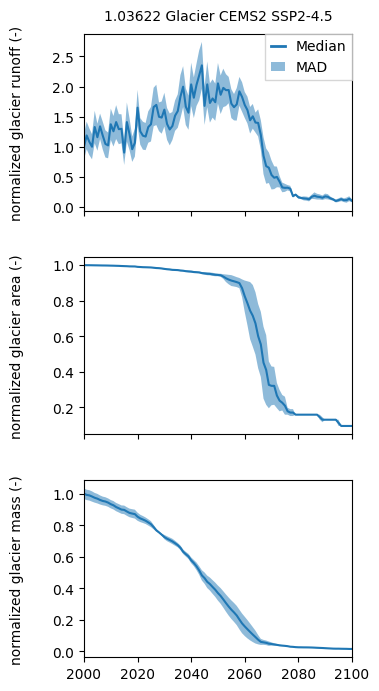

In [17]:
# create 3 x 1 plot with runoff, area, mass
import matplotlib.pyplot as plt
# initialize figure
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)
ax[0].plot(year,runoff[0]/runoff[0][0], label='Median')
ax[0].fill_between(year,
                    (runoff[0] - runoff[1]) / runoff[0][0],
                    (runoff[0] + runoff[1]) / runoff[0][0],
                    alpha=.5,
                    label='MAD')

ax[1].plot(year,area[0]/area[0][0])
ax[1].fill_between(year,
                    (area[0] - area[1]) / area[0][0],
                    (area[0] + area[1]) / area[0][0],
                    alpha=.5)

ax[2].plot(year,mass[0]/mass[0][0])
ax[2].fill_between(year,
                    (mass[0] - mass[1]) / mass[0][0],
                    (mass[0] + mass[1]) / mass[0][0],
                    alpha=.5)

# create legend
leg = ax[0].legend(fancybox=False,borderaxespad=0,handlelength=1,loc='upper right')
# increase linewidths in legend

for line in leg.get_lines():
    line.set_linewidth(2)
    
# set x axis limits to temporal extent of our data
ax[0].set_xlim([2000,2100])
# create x and y axis labels
ax[0].text(-0.25, 0.5, 'normalized glacier runoff (-)', va='center', ha='center', rotation=90, transform=ax[0].transAxes)
ax[1].text(-0.25, 0.5, 'normalized glacier area (-)', va='center', ha='center', rotation=90, transform=ax[1].transAxes)
ax[2].text(-0.25, 0.5, 'normalized glacier mass (-)', va='center', ha='center', rotation=90, transform=ax[2].transAxes)
# title
ax[0].text(.5, 1.1, f'{glac_str} Glacier CEMS2 SSP2-4.5', va='center', ha='center', rotation=0, transform=ax[0].transAxes)
fig.tight_layout()

What's the glacier geometry evolution look like? We can assess this if the binned data was exported from a given glacier simulation.

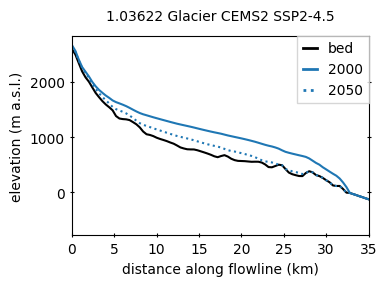

In [18]:
# initialize figure
fig,ax = plt.subplots(1,figsize=(4,3))
# load binned dataset
fn = glob.glob(f'{rootpath}/Output/simulations/{reg}/{gcm_name}/{scenario}/binned/{glac_no}_{gcm_name}_{scenario}_MCMC_*10sets*_2000_2100_binned.nc*')[0]
ds = xr.open_dataset(fn)                                # open netcdf dataset
# get bed height (initial surface height minus initial ice thickness)
bed_height = ds.bin_surface_h_initial[0].values - ds.bin_thick_annual[0].values[:,0]
# get thickness at a desired year
yoi = 2050
idx = ds.year.values.tolist().index(yoi)
end_thick = ds.bin_thick_annual[0].values[:,idx]         # pull thickness from year of interest
# plot bed
ax.plot(ds.bin_distance[0].values*1e-3, bed_height,ls='-',c='k',label='bed')
# plot initial surface
ax.plot(ds.bin_distance[0].values*1e-3, ds.bin_surface_h_initial[0].values,ls='-',c='C0',label=ds.year.values[0])
# plot final surface
ax.plot(ds.bin_distance[0].values*1e-3, bed_height + end_thick,ls=':',c='C0',label=yoi)
# create legend object
leg = ax.legend(fancybox=False,borderaxespad=0,handlelength=1)
# increase linewidths in legend
for line in leg.get_lines():
    line.set_linewidth(2)
# set x and y axis limits to zoom in on area of interest
ax.set_xlim([0,35])
# create x and y axis labels
ax.set_ylabel('elevation (m a.s.l.)')
ax.set_xlabel('distance along flowline (km)')
# modify ticks as desired
ax.tick_params(axis='both', which='major', direction='inout', right=True)
ax.tick_params(axis='both', which='minor', direction='in', right=True)
# title
ax.text(.5, 1.1, f'{glac_str} Glacier CEMS2 SSP2-4.5', va='center', ha='center', rotation=0, transform=ax.transAxes)
fig.tight_layout()

## Next:
Expand on what your learned in the PyGEM test notebooks (try your favorite glacier, or run for an entire region), or explore some of the other demonstration notebooks:
* [*run_calibration.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_calibration.ipynb): demonstrates regional model calibration at the end of the notebook
* [*run_simulation.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_simulation.ipynb): demonstrates regional model simulation at the end of the notebook, also demonstartes some more advanced analyses of glacier geometry for various climate models and scenarios
* [*analyze_regional_change.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/analyze_regional_change.ipynb): demonstrates regional model simulation analysis